# Data Preparation

In this notebook, we will re-construct the dataset.

Graph Neural Networks work by learning representation for nodes or edges of a graph that are well suited for some downstream task. We can model the fraud detection problem as a node classification task, and the goal of the graph neural network would be to learn how to use information from the topology of the sub-graph for each transaction node to transform the node's features to a representation space where the node can be easily classified as fraud or not.

Specifically, we will be using a relational graph convolutional neural network model (R-GCN) on a heterogeneous graph since we have nodes and edges of different types.

## Set up Colab environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
cur_path = "/content/drive/MyDrive/graph-fraud-detection-F/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/graph-fraud-detection-F


## Data Overview

Import the numpy and pandas modules.

In [3]:
import numpy as np
import pandas as pd

## Data Description

### Transaction Table
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

## Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

In [4]:
transaction_df = pd.read_csv('./ieee-data/train_transaction.csv')
identity_df = pd.read_csv('./ieee-data/train_identity.csv')
test_transaction = pd.read_csv('./ieee-data/test_transaction.csv')
test_identity = pd.read_csv('./ieee-data/test_identity.csv')

We provide a general processing framework to convert a relational table to heterogeneous graph edgelists based on the column types of the relational table. Some of the data transformation and feature engineering techniques include:

- Performing numerical encoding for categorical variables and logarithmic transformation for transaction amount
- Constructing graph edgelists between transactions and other entities for the various relation types

The inputs to the data preprocessing script are passed in as python command line arguments. All the columns in the relational table are classifed into one of 3 types for the purposes of data transformation:

- Identity columns --id-cols: columns that contain identity information related to a user or transaction for example IP address, Phone Number, device identifiers etc. These column types become node types in the heterogeneous graph, and the entries in these columns become the nodes. The column names for these column types need to passed in to the script.

- Categorical columns --cat-cols: columns that correspond to categorical features for a user's age group or whether a provided address matches with an address on file. The entries in these columns undergo numerical feature transformation and are used as node attributes in the heterogeneous graph. The columns names for these column types also needs to be passed in to the script

- Numerical columns: columns that correspond to numerical features like how many times a user has tried a transaction and so on. The entries here are also used as node attributes in the heterogeneous graph. The script assumes that all columns in the tables that are not identity columns or categorical columns are numerical columns

In [5]:
id_cols = ['card1','card2','card3','card4','card5','card6','ProductCD','addr1','addr2','P_emaildomain','R_emaildomain']
cat_cols = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
train_data_ratio = 0.8

Based on the train/test ratio we assigned before, extact the IDs of test data.

In [6]:
n_train = int(transaction_df.shape[0]*train_data_ratio)
test_ids = transaction_df.TransactionID.values[n_train:]

In [7]:
get_fraud_frac = lambda series: 100 * sum(series)/len(series)
print("Percent fraud for train transactions: {}".format(get_fraud_frac(transaction_df.isFraud[:n_train])))
print("Percent fraud for test transactions: {}".format(get_fraud_frac(transaction_df.isFraud[n_train:])))
print("Percent fraud for all transactions: {}".format(get_fraud_frac(transaction_df.isFraud)))

Percent fraud for train transactions: 3.5135215226741625
Percent fraud for test transactions: 3.4409184813899145
Percent fraud for all transactions: 3.499000914417313


 Save test IDs into the `test.csv` file

In [8]:
with open('data/test.csv', 'w') as f:
    f.writelines(map(lambda x: str(x) + "\n", test_ids))

Based on the standard we talked about before, define non-feature-columns and feature-columns for creating graph.

In [9]:
non_feature_cols = ['isFraud', 'TransactionDT'] + id_cols
print(non_feature_cols)

['isFraud', 'TransactionDT', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']


In [10]:
feature_cols = [col for col in transaction_df.columns if col not in non_feature_cols]
print(feature_cols)

['TransactionID', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102',

Transfer categorical features to be dummy variables and scale the `TransactionAmt` feature by log10.

In [11]:
features = pd.get_dummies(transaction_df[feature_cols], columns=cat_cols).fillna(0)
features['TransactionAmt'] = features['TransactionAmt'].apply(np.log10)

In [12]:
features.shape

(590540, 391)

In [13]:
print(list(features.columns))

['TransactionID', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109

Save the features into `features.csv` for future training.

p.s. We don't need the index column and header.

In [14]:
features.to_csv('data/features.csv', index=False, header=False)

Save the IDs and label into the `tags.csv`.

In [15]:
transaction_df[['TransactionID', 'isFraud']].to_csv('data/tags.csv', index=False)

Select the columns that define the edges.

In [16]:
edge_types = id_cols + list(identity_df.columns)
print(edge_types)

['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [17]:
all_id_cols = ['TransactionID'] + id_cols
full_identity_df = transaction_df[all_id_cols].merge(identity_df, on='TransactionID', how='left')
full_identity_df.head(5)

,TransactionID,card1,card2,card3,card4,card5,card6,ProductCD,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,13926,NaN,150.0,discover,142.0,credit,W,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,2755,404.0,150.0,mastercard,102.0,credit,W,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,4663,490.0,150.0,visa,166.0,debit,W,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,18132,567.0,150.0,mastercard,117.0,debit,W,476.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,4497,514.0,150.0,mastercard,102.0,credit,H,420.0,87.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


For each identity feature, save the data into the corresponding `relation_{FEATURE NAME}_edgelist.csv`. Each csv file represents one kind of edge.

In [18]:
edges = {}
for etype in edge_types:
    edgelist = full_identity_df[['TransactionID', etype]].dropna()
    edgelist.to_csv('data/relation_{}_edgelist.csv'.format(etype), index=False, header=True)
    edges[etype] = edgelist

print(edges)

{'card1':         TransactionID  card1
0             2987000  13926
1             2987001   2755
2             2987002   4663
3             2987003  18132
4             2987004   4497
...               ...    ...
590535        3577535   6550
590536        3577536  10444
590537        3577537  12037
590538        3577538   7826
590539        3577539  15066

[590540 rows x 2 columns], 'card2':         TransactionID  card2
1             2987001  404.0
2             2987002  490.0
3             2987003  567.0
4             2987004  514.0
5             2987005  555.0
...               ...    ...
590534        3577534  408.0
590536        3577536  225.0
590537        3577537  595.0
590538        3577538  481.0
590539        3577539  170.0

[581607 rows x 2 columns], 'card3':         TransactionID  card3
0             2987000  150.0
1             2987001  150.0
2             2987002  150.0
3             2987003  150.0
4             2987004  150.0
...               ...    ...
590535        357

Let's re-check the edges we defined.

In [22]:
import glob
import networkx as nx
file_list = glob.glob('./data/*edgelist.csv')

edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in file_list if "relation" in file]))

edges_full = ''
for etype in edge_types:
    edges_full += ',data/relation_{}_edgelist.csv'.format(etype)


In [23]:
edges

'relation_card1_edgelist.csv,relation_card2_edgelist.csv,relation_card3_edgelist.csv,relation_card4_edgelist.csv,relation_card5_edgelist.csv,relation_card6_edgelist.csv,relation_ProductCD_edgelist.csv,relation_addr1_edgelist.csv,relation_addr2_edgelist.csv,relation_P_emaildomain_edgelist.csv,relation_R_emaildomain_edgelist.csv,relation_TransactionID_edgelist.csv,relation_id_01_edgelist.csv,relation_id_02_edgelist.csv,relation_id_03_edgelist.csv,relation_id_04_edgelist.csv,relation_id_05_edgelist.csv,relation_id_06_edgelist.csv,relation_id_07_edgelist.csv,relation_id_08_edgelist.csv,relation_id_09_edgelist.csv,relation_id_10_edgelist.csv,relation_id_11_edgelist.csv,relation_id_12_edgelist.csv,relation_id_13_edgelist.csv,relation_id_14_edgelist.csv,relation_id_15_edgelist.csv,relation_id_16_edgelist.csv,relation_id_17_edgelist.csv,relation_id_18_edgelist.csv,relation_id_19_edgelist.csv,relation_id_20_edgelist.csv,relation_id_21_edgelist.csv,relation_id_22_edgelist.csv,relation_id_23_edge

<ipython-input-28-f81d29da9c98>:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


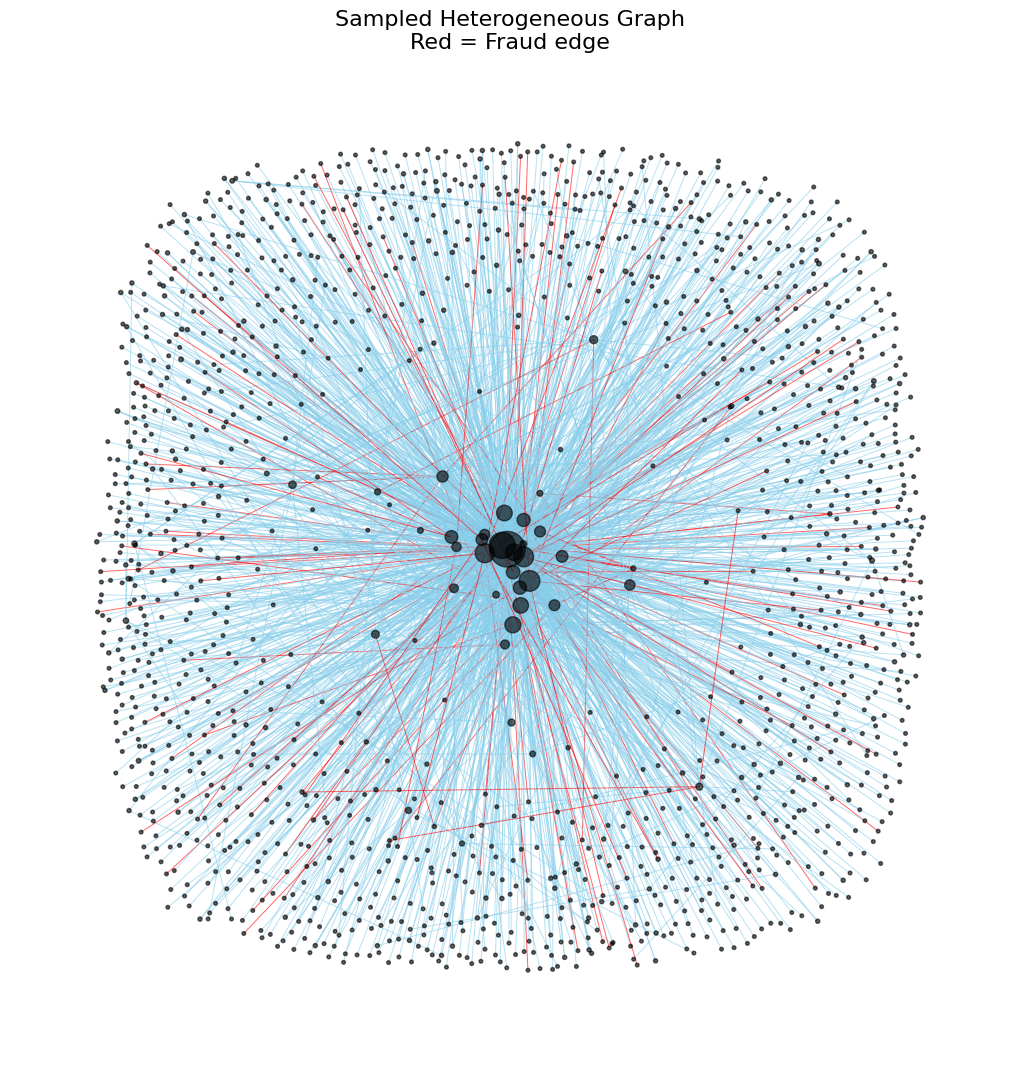

In [28]:
import glob
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Limit: max edges per file (tune as needed)
MAX_EDGES_PER_FILE = 500  # Lower for even less memory

file_list = glob.glob('./data/*edgelist.csv')
all_edges = []
for file in file_list:
    df = pd.read_csv(file)
    if df.shape[1] >= 2:
        src, tgt = df.columns[:2]
        temp = df[[src, tgt]].copy()
        temp.columns = ['TransactionID', 'Other']
        temp['relation'] = file.split('/')[-1].replace('_edgelist.csv','')
        # Randomly sample from each file for diversity
        temp = temp.sample(n=min(MAX_EDGES_PER_FILE, len(temp)), random_state=42)
        all_edges.append(temp)
edges_df = pd.concat(all_edges, ignore_index=True)

# Also sample overall if needed
edges_df = edges_df.sample(n=min(3000, len(edges_df)), random_state=42)

# Load fraud labels (tags)
tags_df = pd.read_csv('./data/tags.csv')
merged = edges_df.merge(tags_df, on='TransactionID', how='left')

# Use simple Graph for speed
G = nx.from_pandas_edgelist(
    merged,
    source='TransactionID',
    target='Other',
    edge_attr=['isFraud', 'relation'],
    create_using=nx.Graph()
)

# Plot largest connected component only
if not nx.is_connected(G):
    Gc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
else:
    Gc = G

# Layout (fast, limited iterations)
pos = nx.spring_layout(Gc, k=0.18, iterations=10, seed=42)

# Edge colors (fraud = red)
edge_colors = [
    'red' if d.get('isFraud', 0) == 1 else 'skyblue'
    for _, _, d in Gc.edges(data=True)
]

# Node sizes by degree (optional, or just a constant value)
node_sizes = [5 + 2*Gc.degree(n) for n in Gc.nodes()]

plt.figure(figsize=(10, 10))
nx.draw(
    Gc, pos,
    node_color='black',
    edge_color=edge_colors,
    node_size=node_sizes,
    width=0.7,
    alpha=0.6,
    with_labels=False
)
plt.title('Sampled Heterogeneous Graph\nRed = Fraud edge', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()



In [29]:
# import pandas as pd
# import networkx as nx
# import glob

# file_list = glob.glob('./data/*edgelist.csv')
# G_train = nx.Graph()

# for file in file_list:
#     df = pd.read_csv(file)
#     print(f"Columns in {file}: {df.columns.tolist()}")

#     # Take the first two columns as source and target
#     source_col, target_col = df.columns[:2]

#     # Build partial graph
#     G_partial = nx.from_pandas_edgelist(
#         df,
#         source=source_col,
#         target=target_col,
#         edge_attr=True
#     )
#     G_train.add_edges_from(G_partial.edges(data=True))

# edge_colors = [
#     G_train.edges[edge].get('isFraud', 0)  # default to 0 if not present
#     for edge in G_train.edges()
# ]

# nx.draw_networkx(
#     G_train,
#     edge_color=edge_colors,
#     node_size=2,
#     with_labels=False,
#     alpha=0.3
# )


In [30]:
# nx.draw_networkx(G_train, edge_color=[G_train.edges[i]['isFraud'] for i in G_train.edges()], node_size=2, with_labels=False,alpha=0.3)
